In [1]:
import numpy as np
import scipy.optimize as op
from itertools import permutations
from scipy.integrate import odeint


# time derivative for sensitivity ODE
def Sensitivity_function(t,x,QSP):
    nparam=QSP.qspcore.nparam
    nvar=QSP.qspcore.nvar
    x=x.reshape(nparam+1,nvar)
    dxdt=np.empty(x.shape)
    dxdt[0]=QSP(t,x[0])
    dxdt[1:]=np.dot(QSP.Ju(t,x[0]),x[1:].T).T+ QSP.Jp(t,x[0])
    return dxdt.flatten()

# Object class that defines the functions for the appropriate QSP Model
class OS_QSP_Functions(object):
    def __init__(self,SSrestrictions=np.ones(23)):
        self.nparam=55
        self.nvar=14
        self.variable_names=['Naive Macrophages  ($M_N$)', 'Macrophages  ($M$)', 'Naive T-cells  ($T_N$)', 'helper T-cells  ($T_h$)', 'Treg-cells  ($T_r$)', 
                             'cytotoxic cells  ($T_c$)', 'Naive Dendritic cells  ($D_N$)', 'Dendritic cells  ($D$)', 'Cancer cells  ($C$)', 'Necrotic cells  ($N$)', 
                             'IFN-$\gamma$  ($I_\gamma$)', '$\mu_1$', '$\mu_2$', 'HMGB1  ($H$)']
        self.SSscale = SSrestrictions

    def __call__(self,t,x,par):
        # ODE right-hand side
        return np.array([par[45] - par[24]*x[0] - par[49]*x[0]*(par[0]*x[10] + par[1]*x[11]), 
                         (-par[25])*x[1] + x[0]*(par[0]*x[10] + par[1]*x[11]), 
                         par[46] - par[26]*x[2] - par[50]*x[2]*(par[2]*x[1] + par[3]*x[7]) - par[52]*x[2]*(par[6]*x[1] + par[5]*x[3] + par[7]*x[7]) - par[4]*par[51]*x[2]*x[11], 
                         x[2]*(par[2]*x[1] + par[3]*x[7]) - x[3]*(par[29] + par[27]*x[4] + par[28]*x[11]), 
                         (-par[30])*x[4] + par[4]*x[2]*x[11], 
                         x[2]*(par[6]*x[1] + par[5]*x[3] + par[7]*x[7]) - x[5]*(par[33] + par[31]*x[4] + par[32]*x[11]), 
                         par[47] - par[34]*x[6] - par[53]*x[6]*(par[8]*x[8] + par[9]*x[13]), 
                         (-x[7])*(par[36] + par[35]*x[8]) + x[6]*(par[8]*x[8] + par[9]*x[13]), 
                         (-x[8])*(par[39] + par[37]*x[5] + par[38]*x[10]) + x[8]*(1 - x[8]/par[48])*(2*par[10] + par[11]*x[11] + par[12]*x[12]), 
                         (-par[40])*x[9] + par[54]*x[8]*(par[39] + par[37]*x[5] + par[38]*x[10]), 
                         par[13]*x[3] + par[14]*x[5] - par[41]*x[10], 
                         par[16]*x[1] + par[15]*x[3] + par[17]*x[8] - par[42]*x[11], 
                         par[19]*x[1] + par[18]*x[3] + par[20]*x[8] - par[43]*x[12], 
                         par[21]*x[1] + par[22]*x[7] + par[23]*x[9] - par[44]*x[13]])
    
    
    def Ju(self,t,x,par):
        # Jacobian with respect to variables
        return np.array([[-par[24] - par[49]*(par[0]*x[10] + par[1]*x[11]), 0, 0, 0, 0, 0, 0, 0, 0, 0, (-par[0])*par[49]*x[0], 
                          (-par[1])*par[49]*x[0], 0, 0], 
                         [par[0]*x[10] + par[1]*x[11], -par[25], 0, 0, 0, 0, 0, 0, 0, 0, par[0]*x[0], par[1]*x[0], 0, 0], 
                         [0, (-par[2])*par[50]*x[2] - par[6]*par[52]*x[2], -par[26] - par[50]*(par[2]*x[1] + par[3]*x[7]) - 
                          par[52]*(par[6]*x[1] + par[5]*x[3] + par[7]*x[7]) - par[4]*par[51]*x[11], (-par[5])*par[52]*x[2], 
                          0, 0, 0, (-par[3])*par[50]*x[2] - par[7]*par[52]*x[2], 0, 0, 0, (-par[4])*par[51]*x[2], 0, 0], 
                         [0, par[2]*x[2], par[2]*x[1] + par[3]*x[7], -par[29] - par[27]*x[4] - par[28]*x[11], (-par[27])*x[3], 
                          0, 0, par[3]*x[2], 0, 0, 0, (-par[28])*x[3], 0, 0], 
                         [0, 0, par[4]*x[11], 0, -par[30], 0, 0, 0, 0, 0, 0, par[4]*x[2], 0, 0], 
                         [0, par[6]*x[2], par[6]*x[1] + par[5]*x[3] + par[7]*x[7], par[5]*x[2], (-par[31])*x[5], -par[33] - 
                          par[31]*x[4] - par[32]*x[11], 0, par[7]*x[2], 0, 0, 0, (-par[32])*x[5], 0, 0], 
                         [0, 0, 0, 0, 0, 0, -par[34] - par[53]*(par[8]*x[8] + par[9]*x[13]), 0, (-par[8])*par[53]*x[6], 
                          0, 0, 0, 0, (-par[9])*par[53]*x[6]], 
                         [0, 0, 0, 0, 0, 0, par[8]*x[8] + par[9]*x[13], -par[36] - par[35]*x[8], par[8]*x[6] - par[35]*x[7], 
                          0, 0, 0, 0, par[9]*x[6]], 
                         [0, 0, 0, 0, 0, (-par[37])*x[8], 0, 0, -par[39] - par[37]*x[5] - par[38]*x[10] - 
                          (x[8]*(2*par[10] + par[11]*x[11] + par[12]*x[12]))/par[48] + 
                          (1 - x[8]/par[48])*(2*par[10] + par[11]*x[11] + par[12]*x[12]), 0, (-par[38])*x[8], 
                          par[11]*x[8]*(1 - x[8]/par[48]), par[12]*x[8]*(1 - x[8]/par[48]), 0], 
                         [0, 0, 0, 0, 0, par[37]*par[54]*x[8], 0, 0, par[54]*(par[39] + par[37]*x[5] + par[38]*x[10]), 
                          -par[40], par[38]*par[54]*x[8], 0, 0, 0], 
                         [0, 0, 0, par[13], 0, par[14], 0, 0, 0, 0, -par[41], 0, 0, 0], 
                         [0, par[16], 0, par[15], 0, 0, 0, 0, par[17], 0, 0, -par[42], 0, 0], 
                         [0, par[19], 0, par[18], 0, 0, 0, 0, par[20], 0, 0, 0, -par[43], 0], 
                         [0, par[21], 0, 0, 0, 0, 0, par[22], 0, par[23], 0, 0, 0, -par[44]]])
    

    def Jp(self,t,x,par):
        # Jacobian with respect to the parameters
        return np.array([[(-par[49])*x[0]*x[10], x[0]*x[10], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [(-par[49])*x[0]*x[11], x[0]*x[11], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-par[50])*x[1]*x[2], x[1]*x[2], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-par[50])*x[2]*x[7], x[2]*x[7], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-par[51])*x[2]*x[11], 0, x[2]*x[11], 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-par[52])*x[2]*x[3], 0, 0, x[2]*x[3], 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-par[52])*x[1]*x[2], 0, 0, x[1]*x[2], 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-par[52])*x[2]*x[7], 0, 0, x[2]*x[7], 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, (-par[53])*x[6]*x[8], x[6]*x[8], 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, (-par[53])*x[6]*x[13], x[6]*x[13], 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 2*x[8]*(1 - x[8]/par[48]), 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, x[8]*(1 - x[8]/par[48])*x[11], 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, x[8]*(1 - x[8]/par[48])*x[12], 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[3], 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[5], 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[3], 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[1], 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[8], 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[3], 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[1], 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[8], 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[1]], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[7]], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x[9]], 
                         [-x[0], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, -x[1], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, -x[2], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, (-x[3])*x[4], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, (-x[3])*x[11], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, -x[3], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, -x[4], 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, (-x[4])*x[5], 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, (-x[5])*x[11], 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, -x[5], 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, -x[6], 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, (-x[7])*x[8], 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, -x[7], 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, (-x[5])*x[8], par[54]*x[5]*x[8], 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, (-x[8])*x[10], par[54]*x[8]*x[10], 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, -x[8], par[54]*x[8], 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, -x[9], 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -x[10], 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -x[11], 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -x[12], 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -x[13]], 
                         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, (x[8]**2*(2*par[10] + par[11]*x[11] + par[12]*x[12]))/par[48]**2, 0, 0, 0, 0, 0], 
                         [(-x[0])*(par[0]*x[10] + par[1]*x[11]), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-x[2])*(par[2]*x[1] + par[3]*x[7]), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-par[4])*x[2]*x[11], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, (-x[2])*(par[6]*x[1] + par[5]*x[3] + par[7]*x[7]), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, (-x[6])*(par[8]*x[8] + par[9]*x[13]), 0, 0, 0, 0, 0, 0, 0], 
                         [0, 0, 0, 0, 0, 0, 0, 0, 0, x[8]*(par[39] + par[37]*x[5] + par[38]*x[10]), 0, 0, 0, 0]])

    
    def SS_system(self,par,frac,meanvals):
        # compute the system and restrictions with non-dimensional steady states at 1 pre-defined rates
        # meanvals as given as [M1 M2 M Th Tr Tc D C N Ig mu1 mu2 H]
        x=np.ones(self.nvar);
        # rates acquired from bio research [delMn delM delTn delTh delTr delTc delDn delD delIg delmu1 delmu2 delH]
        globvals=np.array([0.693, 0.015, 0.00042, 0.231, 0.063, 0.406, 1.664, 0.277, 33.27, 487.48, 5.15, 58.7])

        return np.array([par[45] - par[24]*x[0] - par[49]*x[0]*(par[0]*x[10] + par[1]*x[11]), 
                         (-par[25])*x[1] + x[0]*(par[0]*x[10] + par[1]*x[11]), 
                         par[46] - par[26]*x[2] - par[50]*x[2]*(par[2]*x[1] + par[3]*x[7]) - par[52]*x[2]*(par[6]*x[1] + par[5]*x[3] + par[7]*x[7]) - par[4]*par[51]*x[2]*x[11], 
                         x[2]*(par[2]*x[1] + par[3]*x[7]) - x[3]*(par[29] + par[27]*x[4] + par[28]*x[11]), 
                         (-par[30])*x[4] + par[4]*x[2]*x[11], 
                         x[2]*(par[6]*x[1] + par[5]*x[3] + par[7]*x[7]) - x[5]*(par[33] + par[31]*x[4] + par[32]*x[11]), 
                         par[47] - par[34]*x[6] - par[53]*x[6]*(par[8]*x[8] + par[9]*x[13]), 
                         (-x[7])*(par[36] + par[35]*x[8]) + x[6]*(par[8]*x[8] + par[9]*x[13]), 
                         (-x[8])*(par[39] + par[37]*x[5] + par[38]*x[10]) + x[8]*(1 - x[8]/par[48])*(2*par[10] + par[11]*x[11] + par[12]*x[12]), 
                         (-par[40])*x[9] + par[54]*x[8]*(par[39] + par[37]*x[5] + par[38]*x[10]), 
                         par[13]*x[3] + par[14]*x[5] - par[41]*x[10], 
                         par[16]*x[1] + par[15]*x[3] + par[17]*x[8] - par[42]*x[11], 
                         par[19]*x[1] + par[18]*x[3] + par[20]*x[8] - par[43]*x[12], 
                         par[21]*x[1] + par[22]*x[7] + par[23]*x[9] - par[44]*x[13],
                         # cancer growth rate
                         self.SSscale[0]*par[10] - 0.01662,
                         # assumptions (21)
                         self.SSscale[1]*par[10] - 20*par[12]*meanvals[11]/frac[12],
                         self.SSscale[2]*par[10] - 40*par[11]*meanvals[10]/frac[11],
                         self.SSscale[3]*par[38]*meanvals[9]/frac[10] - 10*par[39],
                         self.SSscale[4]*par[37]*meanvals[5]/frac[5] - 20*par[39],
                         self.SSscale[5]*par[0]*(meanvals[9]/frac[10])*meanvals[1] - par[1]*(meanvals[10]/frac[11])*meanvals[0],
                         self.SSscale[6]*par[3]*meanvals[6]/frac[7] - 200*par[2]*meanvals[2]/frac[1],
                         self.SSscale[7]*par[28]*meanvals[10]/frac[11] - 20*par[29],
                         self.SSscale[8]*par[27]*meanvals[4]/frac[4] - 20*par[29],
                         self.SSscale[9]*par[7]*meanvals[6]/frac[7] - 2*par[5]*meanvals[3]/frac[3],
                         self.SSscale[10]*par[7]*meanvals[6]/frac[7] - 4*par[6]*meanvals[2]/frac[1],
                         self.SSscale[11]*par[32]*meanvals[10]/frac[11] - 20*par[33],
                         self.SSscale[12]*par[31]*meanvals[4]/frac[4] - 20*par[33],
                         self.SSscale[13]*par[9]*meanvals[12]/frac[13] - 2*par[8]*meanvals[7]/frac[8],
                         self.SSscale[14]*par[35]*meanvals[7]/frac[8] - par[36],
                         self.SSscale[15]*par[14]*meanvals[5]/frac[5] - 4*par[13]*meanvals[3]/frac[3],
                         self.SSscale[16]*par[15]*meanvals[3]/frac[3] - par[16]*meanvals[2]/frac[1],
                         self.SSscale[17]*par[15]*meanvals[3]/frac[3] - par[17]*meanvals[7]/frac[8],
                         self.SSscale[18]*par[19]*meanvals[2]/frac[1] - par[20]*meanvals[7]/frac[8],
                         self.SSscale[19]*par[19]*meanvals[2]/frac[1] - 2*par[18]*meanvals[3]/frac[3],
                         self.SSscale[20]*par[23]*meanvals[8]/frac[9] - 10*par[21]*meanvals[2]/frac[1],
                         self.SSscale[21]*par[23]*meanvals[8]/frac[9] - 20*par[22]*meanvals[6]/frac[7],
                         # decay rates (12)
                         par[24] - globvals[0],
                         par[25] - globvals[1],
                         par[26] - globvals[2],
                         par[29] - globvals[3],
                         par[30] - globvals[4],
                         par[33] - globvals[5],
                         par[34] - globvals[6],
                         par[36] - globvals[7],
                         par[41] - globvals[8],
                         par[42] - globvals[9],
                         par[43] - globvals[10],
                         par[44] - globvals[11],
                         # alphas (5)
                         par[49] - frac[1]/frac[0],
                         par[50] - frac[3]/frac[2],
                         par[51] - frac[4]/frac[2],
                         par[52] - frac[5]/frac[2],
                         par[53] - frac[7]/frac[6],
                         # C0 and alpha_NC
                         par[48] - 2,
                         self.SSscale[22]*0.75*frac[8]/frac[9] - par[54]])



class QSP:
    def __init__(self,parameters,qspcore=OS_QSP_Functions()):
        self.qspcore=qspcore
        self.par=parameters;
    def set_parameters(self,parameters):
        self.par=parameters;
    def steady_state(self):
        # compute steady state with current parameters
        IC=np.ones(self.qspcore.nvar);
        return op.fsolve((lambda x: self.qspcore(0,x,self.par)),IC,fprime=(lambda x: self.qspcore.Ju(0,x,self.par)),xtol=1e-7,maxfev=10000)
        # return op.root((lambda x,QSP: QSP(0,x,self.par)),IC,args=(self.qspcore,), method='hybr')
    def Sensitivity(self,method='steady',t=None,IC=None,params=None,variables=None):
        # Sensitivity matrix
        # method: (default) 'steady' - steady state sensitivity
                # 'time' - time-integrated sensitivity
                        # requires time array t and initial conditions IC
                # 'split' - steady state sensitivity with respect to chosen parameters
                        # requires initiate_parameter_split to have been run
                        # takes optional argument 'variables' for sensitivity of specific variables.
        if method=='time':
            if IC is None:
                raise Exception('Error: Need initial conditions for time integration. Set IC=')
                return None
            if t is None:
                raise Exception('Error: Need time values for time integration. Set t=')
                return None
            
            nparam=self.qspcore.nparam
            nvar=self.qspcore.nvar
            initial=np.zeros((nparam+1,nvar));
            initial[0]=IC
            return np.mean(odeint(Sensitivity_function, initial.flatten(), t, args=(self, ), tfirst=True) ,axis=0).reshape(nparam+1,nvar)[1:]
        elif method=='split':
            if not hasattr(self,'variable_par'):
                raise Exception('error: parameter splitting is not set. use "initiate_parameter_split" method')
                return None
            if params is None:
                raise Exception('error: Need parameter values for split sensitivity. Set params=')
                return None
            elif len(params)!=sum(self.variable_par):
                raise Exception('error: wrong number of parameters given')
                return None
            
            if IC is None:
                IC=np.ones(self.qspcore.nvar);
            par=np.copy(self.par)
            par[self.variable_par]=np.copy(params)
            
            u=op.fsolve((lambda x: self.qspcore(0,x,par)),IC,fprime=(lambda x: self.qspcore.Ju(0,x,par)),xtol=1e-7,maxfev=10000)
            if variables is None:
                return -np.dot(self.qspcore.Jp(0,u,self.par),np.linalg.inv(self.qspcore.Ju(0,u,self.par).T))[self.variable_par]
            else:
                return -np.dot(self.qspcore.Jp(0,u,self.par),np.linalg.inv(self.qspcore.Ju(0,u,self.par).T))[self.variable_par,variables]
        else:
            u=self.steady_state()
            return -np.dot(self.qspcore.Jp(0,u,self.par),np.linalg.inv(self.qspcore.Ju(0,u,self.par).T))
        
    def __call__(self,t,x):
        return self.qspcore(t,x,self.par)
    def Ju(self,t,x):
        return self.qspcore.Ju(t,x,self.par)
    def Jp(self,t,x):
        return self.qspcore.Jp(t,x,self.par)
    def variable_names(self):return self.qspcore.variable_names
    def parameter_names(self):return self.qspcore.parameter_names
    def solve_ode(self, t, IC, method='default'):
        # Solve ode system with either default 1e4 time steps or given time discretization
        # t - time: for 'default' needs start and end time
        #           for 'given' needs full array of time discretization points
        # IC - initial conditions
        # method: 'default' - given interval divided by 10000 time steps 
        #         'given' - given time discretization
        if method=='given': 
            return odeint((lambda t,x: self.qspcore(t,x,self.par)), IC, t, 
                            Dfun=(lambda t,x: self.qspcore.Ju(t,x,self.par)), tfirst=True), t
        else: 
            return odeint((lambda t,x: self.qspcore(t,x,self.par)), IC, np.linspace(min(t), max(t), 10001), 
                            Dfun=(lambda t,x: self.qspcore.Ju(t,x,self.par)), tfirst=True), np.linspace(min(t), max(t), 10001)
        
    def initiate_parameter_split(self,variable_par):
        # splits the parameters into fixed and variable for further fittin
        # variable_par - boolean array same size as parameter array indicating which parameters are variable
        if (variable_par.dtype!='bool') or (len(variable_par)!=self.qspcore.nparam):
            raise Exception('error: wrong parameter indicator')
            return None
        self.variable_par=np.copy(variable_par)
    def solve_ode_split(self, t, IC, params):
        # Solve ode system with adjusted variable parameters
        #   using either default 1e4 time steps or given time discretization
        # t - time: needs full array of time discretization points
        # IC - initial conditions
        # params - parameters to update for this solution
        if not hasattr(self,'variable_par'):
            raise Exception('error: parameter splitting is not set. use "initiate_parameter_split" method')
            return None
        if len(params)!=sum(self.variable_par):
            raise Exception('error: wrong number of parameters given')
            return None
        par=np.copy(self.par)
        par[self.variable_par]=np.copy(params)
        return odeint((lambda t,x: self.qspcore(t,x,par)), IC, t, 
                            Dfun=(lambda t,x: self.qspcore.Ju(t,x,par)), tfirst=True)
    
    @classmethod
    def from_cell_data(class_object, fracs, meanvals, qspcore=OS_QSP_Functions()):
        params=op.fsolve((lambda par,frac,meanvals: qspcore.SS_system(par,frac,meanvals)),np.ones(qspcore.nparam),
                         args=(fracs, meanvals))
        return class_object(params,qspcore)


In [2]:
import pandas as pd
import csv
import os
import scipy as sp

# Checking or creating necessary output folders
if not os.path.exists('Data/'):
    os.makedirs('Data/Dynamic/')
    os.makedirs('Data/GlobalSensitivity/')
else:
    if not os.path.exists('Data/Dynamic/'):
        os.makedirs('Data/Dynamic/')
    if not os.path.exists('Data/GlobalSensitivity/'):
        os.makedirs('Data/GlobalSensitivity/')    

# some global parameters
lmod=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #indices of immune cells variables in cell data
clusters=3 #number of clusters

T=2500
t=np.linspace(0, T, 25001)

nvar=OS_QSP_Functions().nvar # number of variables
nparam=OS_QSP_Functions().nparam # number of parameters

In [3]:
clustercells = pd.read_csv('input/TARGET_steady_states.csv')
clustercells.drop('Unnamed: 0', axis=1, inplace=True)
clustercells = clustercells.to_numpy()
clustercells

array([[6.23628422e+06, 1.97698664e+07, 4.92643411e+06, 7.09232768e+06,
        3.67453197e+06, 2.29234191e+07, 4.82635020e+05, 9.86482316e+05,
        1.34316462e+10, 3.76383597e+08, 8.68281406e-01, 2.15101759e+01,
        2.06743704e+00, 5.07626709e+00],
       [3.24826212e+07, 1.84245210e+07, 1.04668831e+07, 1.97280133e+06,
        8.67330754e+05, 3.15516318e+05, 8.92741134e+05, 7.13496721e+05,
        1.60384336e+10, 4.25728046e+08, 4.85189112e-02, 2.07135306e+01,
        1.61095616e+00, 4.94846530e+00],
       [1.94420548e+07, 2.69818025e+07, 1.36828156e+07, 1.20481096e+06,
        1.40486275e+06, 1.80233578e+06, 4.59058119e+05, 3.73208971e+05,
        1.33964870e+10, 1.54386533e+09, 2.63541625e-01, 2.36630324e+01,
        1.37069997e+00, 4.45310149e+00]])

In [4]:
meanvals = pd.read_csv('input/TARGET_avg_by_cluster.csv')
meanvals.drop('Unnamed: 0', axis=1, inplace=True)
meanvals = meanvals.to_numpy()
meanvals

array([[3.50731079e+06, 1.46121747e+07, 1.81194855e+07, 3.71464480e+06,
        2.55653005e+06, 1.12391803e+07, 5.51454254e+05, 6.89865137e+09,
        2.99778307e+08, 5.68696060e-01, 2.40898781e+01, 2.40606458e+00,
        5.03802856e+00],
       [1.32177351e+06, 1.58810699e+07, 1.72028434e+07, 1.89443548e+06,
        1.26279707e+06, 6.78902704e+05, 3.47996510e+05, 6.95647009e+09,
        4.90622573e+08, 7.85318279e-02, 2.39665527e+01, 2.11795870e+00,
        4.92926109e+00],
       [1.62524517e+06, 2.48640143e+07, 2.64892594e+07, 1.22242770e+06,
        1.27287676e+06, 1.05245883e+06, 1.65403320e+05, 5.04869965e+09,
        5.04394789e+08, 7.63615514e-02, 2.41617319e+01, 1.96694821e+00,
        4.78362069e+00]])

In [5]:
# Compute parameter values for each cluster

for cluster in range(clusters):
    QSP_=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
    params=QSP_.par
    print(params)

[4.36488286e-03 1.06351171e-02 3.34338010e-02 1.09632089e+01
 6.30000000e-02 6.11705939e+00 1.74782953e+00 1.14625437e+01
 4.01135041e-01 4.15182835e-01 1.66200000e-02 3.71005534e-04
 7.14045749e-04 6.30949705e+00 2.69605030e+01 1.88128304e+02
 1.07507933e+02 1.91843763e+02 1.23134435e+00 1.40732982e+00
 2.51132583e+00 4.40457629e+00 3.61073888e+00 5.06846848e+01
 6.93000000e-01 1.50000000e-02 4.20000000e-04 6.64038262e+00
 4.12526009e+00 2.31000000e-01 6.30000000e-02 1.16709755e+01
 7.25045713e+00 4.06000000e-01 1.66400000e+00 5.39317876e-01
 2.77000000e-01 1.22694434e-02 4.59230146e-03 3.00780798e-04
 4.59347142e-01 3.32700000e+01 4.87480000e+02 5.15000000e+00
 5.87000000e+01 7.40552033e-01 1.05812071e+02 3.33251371e+00
 2.00000000e+00 3.17013556e+00 1.43964732e+00 7.45880669e-01
 4.65314640e+00 2.04395097e+00 2.67645422e+01]
[8.42336563e-04 1.41576634e-02 1.92697832e-02 7.37781819e+00
 6.30000000e-02 2.38464327e+00 1.22626932e+00 9.39002992e+00
 4.89420767e-01 4.26214351e-01 1.66200

C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


#### Solve ODE + plot dynamics

In [6]:
# reading initial conditions
IC=pd.read_csv('input/TARGET_nondimensional_initial_conditions.csv')
IC.drop('Unnamed: 0', axis=1, inplace=True)
IC = IC.to_numpy()

for cluster in range(clusters):
    print('Starting computations for cluster '+str(cluster+1)) 
    filename='Cluster-'+str(cluster+1)+'-results-'

    QSP_=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
    params=QSP_.par
    
    print(' Parameters set. Computing the solution')

    u, _ = QSP_.solve_ode(t, IC[cluster], 'given')
    u = clustercells[cluster]*u
    
    wr=np.empty((t.size, 15))
    wr[:,0]=t
    wr[:,1:]=u
    c=csv.writer(open('Data/Dynamic/'+filename+'dat.csv',"w"))  
    c.writerow(['time (days)']+QSP_.variable_names())
    c.writerows(wr)
    del c

C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Starting computations for cluster 1
 Parameters set. Computing the solution
Starting computations for cluster 2
 Parameters set. Computing the solution
Starting computations for cluster 3
 Parameters set. Computing the solution


In [7]:
def plot_dynamics(name='-results-', savefig=False, figname=None):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import seaborn as sns

    dynamic_all = []
    for c in [1,2,3]:
        filename='Cluster-'+str(c)+name
        dat = pd.read_csv('Data/Dynamic/'+filename+'dat.csv')
        dat['Total cells'] = dat[dat.columns[1:-4]].sum(axis=1)
        dat['Cluster'] = c
        dynamic_all.append(dat)

    dynamic_all_df = pd.concat(dynamic_all, axis=0)

    palette={'Cluster 1':'#3F9B0B', 'Cluster 2':'#FF796C', 'Cluster 3':'#0343DF'}
    dynamic_all_df['Cluster'] = dynamic_all_df['Cluster'].apply(lambda x: 'Cluster '+str(x))
    custom_lines = [Line2D([0], [0], color='#3F9B0B', lw=1.5), 
                    Line2D([0], [0], color='#FF796C', lw=1.5),
                    Line2D([0], [0], color='#0343DF', lw=1.5)]

    fig, axs = plt.subplots(3, 5, sharey=False, figsize=(21,12))
    fig.subplots_adjust(wspace=0.35, hspace=0.35)
    axs = axs.flatten()
    plt.rcParams.update({'font.size': 14})

    for i, col in enumerate(dynamic_all_df.columns[1:-1]):
        sns.lineplot(data=dynamic_all_df, x='time (days)', y=col, hue='Cluster', palette=palette, ax=axs[i], legend=False)
        axs[i].margins(x=0)

    axs[9].legend(custom_lines, ['Cluster 1', 'Cluster 2', 'Cluster 3'], bbox_to_anchor=(1.08, 0.5), loc='center left')

    if savefig:
        if not figname: figname = filename
        fig.savefig('Figures/'+figname+'.png', bbox_inches='tight')   
        fig.savefig('Figures/'+figname+'.pdf', bbox_inches='tight')   
        fig.savefig('Figures/'+figname+'.eps', bbox_inches='tight')   
    plt.show()

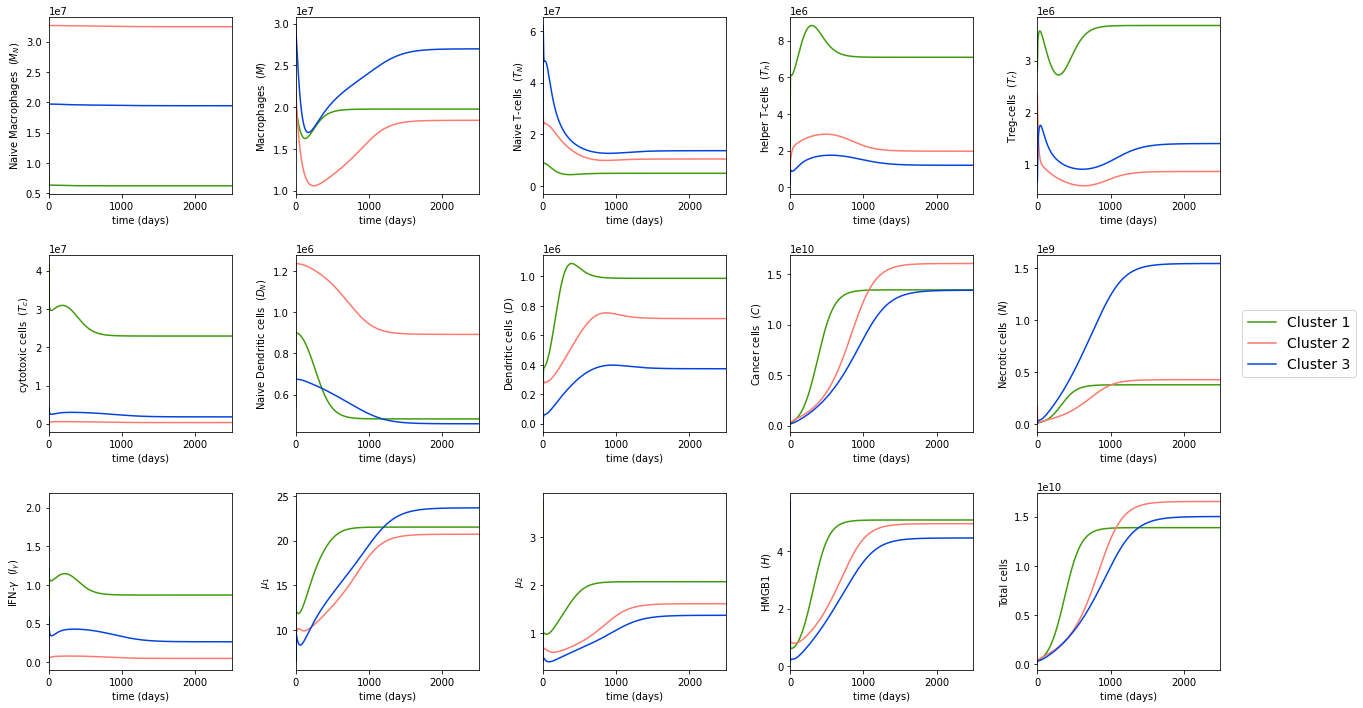

In [9]:
plot_dynamics(name='-results-', savefig=False, figname='Main_dynamics')

### Run global sensitivity analysis

In [25]:
# Sensitivity Analysis
print('Starting steady state global sensitivity analysis')

# Read the parameter perturbation grid
globalgridname='lhs23-5000'
paramscalinggrid = pd.read_csv('input/'+globalgridname+'.csv', header=None).to_numpy().T
lhsnum=paramscalinggrid.shape[0]
# modify from (0,1) range to fit our needs
# paramscalinggrid[:,:22]=pow(10,2*paramscalinggrid[:,:22]-1) # scale to values between 0.1 and 10 (10^-1 to 10^1)
paramscalinggrid[:,:22]=pow(10,4*paramscalinggrid[:,:22]-2) # scale to values between 0.01 and 100 (10^-2 to 10^2)
paramscalinggrid[:,22]=paramscalinggrid[:,22]/0.75

# Read the local parameter perturbation grid 
# level 1 or 0 corresponds to no local perturbation 
gridlevel=2
sensitivity_radius=1 # percentage for local perturbation
if gridlevel>1:
    localgridname='Local-level'+str(gridlevel)
    filename='grid55-level'+str(gridlevel)
    data = pd.read_csv('input/'+filename+'.csv', header=None).to_numpy()
    w=data[:,0]
    x=data[:,1:]
    del data, filename
else:
    localgridname='Local-nogrid'
    w=np.array([1])
    x=[0]

# coefficients for variable sensitivity
lambda0=np.zeros((nvar,2))
lambda0[8,0]=1 # just cancer

Starting steady state global sensitivity analysis


In [13]:
import time

start = time.time()
k_filter_all_clusters = []

for cluster in range(clusters):
    print('Starting computations for cluster '+str(cluster+1)) 
    
    filename='V55-'+globalgridname+'-'+localgridname+'-cluster-'+str(cluster+1)+'-results-'

    # Calculating all the parameters and weights
    basecore=OS_QSP_Functions()
    baseparams=op.fsolve((lambda par,frac,meanvals: basecore.SS_system(par,frac,meanvals)),
                            np.ones(nparam),args=(clustercells[cluster], meanvals[cluster]))
                            
    paramarray=np.empty((lhsnum,nparam))
    weights=np.empty(lhsnum)
    nonnegs=np.ones(lhsnum, dtype=bool)
    for k in range(lhsnum):
        qspcore=OS_QSP_Functions(SSrestrictions=paramscalinggrid[k])
        paramarray[k]=op.fsolve((lambda par,frac,meanvals: qspcore.SS_system(par,frac,meanvals)),
                                np.ones(nparam),args=(clustercells[cluster], meanvals[cluster]))
        if (paramarray[k]<0).any(): nonnegs[k]=False
        weights[k]=np.sqrt(((paramarray[k]-baseparams)**2).sum())

    weights/=weights[nonnegs].min()
    weights=np.exp(-weights)
    weights/=weights[nonnegs].sum()   

    lambda0[0:10,1]=clustercells[cluster,lmod]/np.sum(clustercells[cluster,lmod]) # all cells    
    dudp=np.zeros((nparam,2))
    
    k_filter = []
    
    for k in range(lhsnum):
        if nonnegs[k]:
            for l in range(w.size):
                QSP_=QSP(paramarray[k]*(1+(sensitivity_radius*1e-2)*x[l]))
                cancer_sensitivity = np.dot(np.abs(QSP_.Sensitivity()),lambda0)[:,0]
                # filter out singularities
                if any(x > 10000 for x in cancer_sensitivity):
                    k_filter.append(k)
                    k_filter_all_clusters.append(k)
                    
    k_filter = set(k_filter)
    k_new = [k for k in range(lhsnum) if k not in k_filter]
    
    for k in k_new:
        if nonnegs[k]:
            for l in range(w.size):
                QSP_=QSP(paramarray[k]*(1+(sensitivity_radius*1e-2)*x[l]))
                dudp=dudp+weights[k]*w[l]*np.dot(QSP_.Sensitivity(),lambda0)                        

    print(' Writing to file')

    c=csv.writer(open('Data/GlobalSensitivity/'+filename+'sensitivity_steady.csv',"w"))
    c.writerows(dudp)
    del c
    
end = time.time()
print('Run time: ', end - start)
print('Global sensitivity analysis complete')

Starting computations for cluster 1


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 10000.
  warnings.warn(msg, RuntimeWarning)


 Writing to file
Starting computations for cluster 2
 Writing to file
Starting computations for cluster 3
 Writing to file
Run time:  5361.532153606415
Global sensitivity analysis complete


In [14]:
par_list = ['lamMIg', 'lamMmu1', 'lamThM', 'lamThD', 'lamTrmu1', 'lamTcTh', 'lamTcM', \
'lamTcD', 'lamDC', 'lamDH', 'lamC', 'lamCmu1', 'lamCmu2', 'lamIgTh', 'lamIgTc', \
'lammu1Th', 'lammu1M', 'lammu1C', 'lammu2Th', 'lammu2M', 'lammu2C', 'lamHM', 'lamHD', \
'lamHN', 'delMn', 'delM', 'delTn', 'delThTr', 'delThmu1', 'delTh', 'delTr', \
'delTcTr', 'delTcmu1', 'delTc', 'delDn', 'delDC', 'delD', 'delCTc', 'delCIg', 'delC', \
'delN', 'delIg', 'delmu1', 'delmu2', 'delH', 'AMn', 'ATn', 'ADn', 'C0', 'alphaMnM', 'alphaTnTh', 'alphaTnTr', \
'alphaTnTc', 'alphaDnD', 'alphaNC']

In [15]:
for cluster in range(clusters):
    filename='V55-'+globalgridname+'-'+localgridname+'-cluster-'+str(cluster+1)+'-results-'
    sensitivity_df = pd.read_csv('Data/GlobalSensitivity/'+filename+'sensitivity_steady.csv', header=None)
    sensitivity_df.index = par_list
    sensitive_ids = np.abs(sensitivity_df)[0].nlargest(n=15).index
    print('Cluster ', cluster+1)
    print('Sensitivities:\n', sensitivity_df.loc[sensitive_ids])

Cluster  1
Sensitivities:
                    0           1
delCTc   -586.303557 -568.578783
delCIg   -586.089619 -568.372866
lamC      576.744707  570.630086
delC     -576.734934 -559.241523
lamCmu2   286.528956  283.505240
lamCmu1   285.195464  282.215529
lamMIg     12.594339   12.381150
delM      -12.395180  -12.191837
lamMmu1    11.494559   11.304773
lamTrmu1    8.742967    8.472012
delTr      -8.719734   -8.449325
C0          0.854029    0.840269
delTc       0.355089    0.344087
delTcmu1    0.345681    0.334928
delTcTr     0.340814    0.330209
Cluster  2
Sensitivities:
                     0           1
delCTc    -550.629016 -535.944521
delCIg    -549.688215 -535.034077
lamC       541.481893  535.956625
delC      -532.494918 -518.185249
lamCmu2    266.218906  263.539364
lamCmu1    264.127824  261.495865
alphaTnTc    7.155359    6.954083
lamTrmu1     6.939248    6.762053
delTr       -6.877229   -6.701635
lamMIg       6.277015    6.254952
delM        -4.160654   -4.186188
lamMmu1   

In [23]:
par_list = ['\lambda_{MI_\gamma}', '\lambda_{M\mu_1}', '\lambda_{T_hM}', '\lambda_{T_hD}', 
            '\lambda_{T_r\mu_1}', '\lambda_{T_cT_h}', '\lambda_{T_cM}', '\lambda_{T_cD}', '\lambda_{DC}', '\lambda_{DH}', 
            '\lambda_{C}', '\lambda_{C\mu_1}', '\lambda_{C\mu_2}', '\lambda_{I_\gammaT_h}', '\lambda_{I_\gammaT_c}',
            '\lambda_{\mu_1T_h}', '\lambda_{\mu_1M}', '\lambda_{\mu_1C}', '\lambda_{\mu_2T_h}', '\lambda_{\mu_2M}', 
            '\lambda_{\mu_2C}', '\lambda_{HM}', '\lambda_{HD}', '\lambda_{HN}', '\delta_{M_N}', '\delta_{M}',
            '\delta_{T_N}', '\delta_{T_hT_r}', '\delta_{T_h\mu_1}', '\delta_{T_h}', '\delta_{T_r}', 
            '\delta_{T_cT_r}', '\delta_{T_c\mu_1}', '\delta_{T_c}', '\delta_{D_N}', '\delta_{DC}', '\delta_{D}', '\delta_{CT_c}',
            '\delta_{CI_\gamma}', '\delta_{C}', '\delta_{N}', '\delta_{I_\gamma}', '\delta_{\mu_1}', '\delta_{\mu_2}', 
            '\delta_{H}', 'A_{M_N}', 'A_{T_N}', 'A_{D_N}', 'C_0', '\alpha_{M_NM}', '\alpha_{T_NT_h}', 
            '\alpha_{T_NT_r}', '\alpha_{T_NT_c}', '\alpha_{D_ND}', '\alpha_{NC}']
par_list = ['$'+x+'$' for x in par_list]

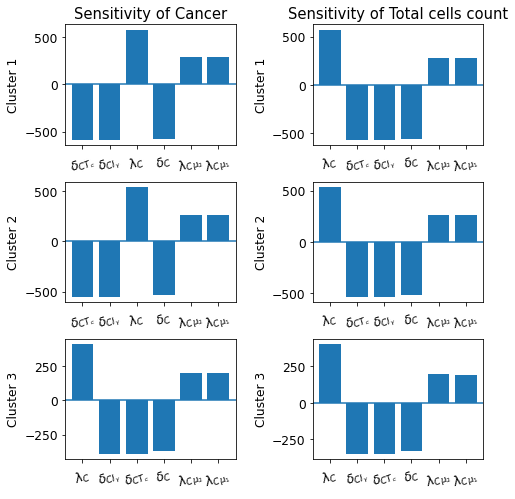

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, sharey=False, figsize=(7.5,8))
fig.subplots_adjust(wspace=0.45, hspace=0.3)
plt.rcParams.update({'font.size': 12.3})

axs[0, 0].set_title('Sensitivity of Cancer')
axs[0, 1].set_title('Sensitivity of Total cells count')

for cluster in range(clusters):
    filename='V55-'+globalgridname+'-'+localgridname+'-cluster-'+str(cluster+1)+'-results-'
    sensitivity_df = pd.read_csv('Data/GlobalSensitivity/'+filename+'sensitivity_steady.csv', header=None)
    sensitivity_df.index = par_list
    for i in range(2):
        sensitive_ids = np.abs(sensitivity_df)[i].nlargest(n=15).index
        sensitivity_df[i][sensitive_ids[:6]].plot.bar(ax=axs[cluster, i], rot=20, width=0.8)
        axs[cluster, i].axhline()
        axs[cluster, i].set_ylabel('Cluster '+str(cluster+1))
    
plt.rc('xtick',labelsize=12.7)
fig.savefig('Sensitivity.pdf', bbox_inches='tight')   
fig.savefig('Sensitivity.eps', bbox_inches='tight')

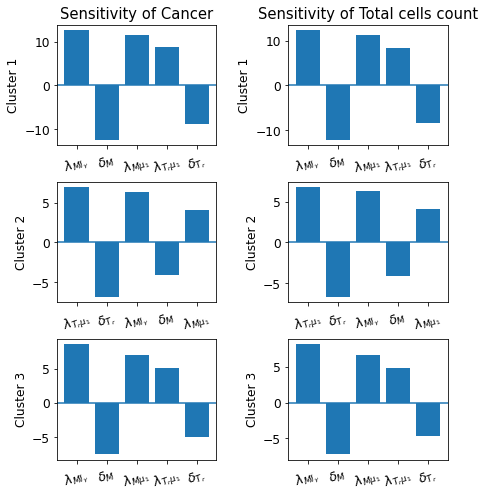

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, sharey=False, figsize=(7,8))
fig.subplots_adjust(wspace=0.45, hspace=0.3)
plt.rcParams.update({'font.size': 12.3})

axs[0, 0].set_title('Sensitivity of Cancer')
axs[0, 1].set_title('Sensitivity of Total cells count')

for cluster in range(clusters):
    filename='V55-'+globalgridname+'-'+localgridname+'-cluster-'+str(cluster+1)+'-results-'
    sensitivity_df = pd.read_csv('Data/GlobalSensitivity/'+filename+'sensitivity_steady.csv', header=None)
    sensitivity_df.index = par_list
    ids_to_remove = ['$\lambda_{C}$', '$\lambda_{C\mu_1}$', '$\lambda_{C\mu_2}$', '$\delta_{CT_c}$', '$\delta_{CI_\gamma}$', 
                     '$\delta_{C}$', '$\delta_{N}$', '$C_0$', '$\alpha_{M_NM}$', '$\alpha_{M_NO}$', '$\alpha_{T_NT_h}$', 
                     '$\alpha_{T_NT_r}$', '$\alpha_{T_NT_c}$', '$\alpha_{D_ND}$', '$\alpha_{NC}$']
    for i in range(2):
        sensitive_ids = np.abs(sensitivity_df)[i].nlargest(n=20).index
        sensitive_ids = [x for x in sensitive_ids if x not in ids_to_remove]
        sensitivity_df[i][sensitive_ids[:5]].plot.bar(ax=axs[cluster, i], rot=20, width=0.8)
        axs[cluster, i].axhline()
        axs[cluster, i].set_ylabel('Cluster '+str(cluster+1))
        
plt.rc('xtick', labelsize=12.7)
fig.savefig('Immune_sensitivity.pdf', bbox_inches='tight')   
fig.savefig('Immune_sensitivity.eps', bbox_inches='tight')

### Get dynamics (solve ODE) with varying sensitive paramters

In [20]:
def plot_cancer_vary_assumption_perturb_sensitive_params(assumption_idx, assumption_scale, perturb_scale, T):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    
    restriction_map = {0: 'lamC', 1: 'lamC-lamCmu2', 2: 'lamC-lamCmu1', 3: 'delCIg-delC', 4: 'delCTc-delC', 5: 'lamMIg-lamMmu1'}
    perturb_map = {0: 'no perturbation', -perturb_scale: '-'+str(perturb_scale*10)+'%', perturb_scale: '+'+str(perturb_scale*10)+'%'}
    palette = {0:'#3F9B0B', 1:'#FF796C', 2:'#0343DF'}
    alphas = [0.2, 0.15, 0.15]
    restrictions = np.ones(23)
    
    fig, axs = plt.subplots(1, 3, sharey=False, figsize=(12.2,3))
    fig.subplots_adjust(wspace=0.3)
    axs = axs.flatten()
    t = np.linspace(0, T, 10*T+1)
    plt.rcParams.update({'font.size': 12.5})
    
    custom_lines = [Line2D([0], [0], color='#3F9B0B', lw=1.5),
                    Line2D([0], [0], color='#FF796C', lw=1.5),
                    Line2D([0], [0], color='#0343DF', lw=1.5)]
    
    for i, newscale in enumerate([1, 1/assumption_scale, assumption_scale]):
        for cluster in range(3):
            restrictions[assumption_idx] = newscale
            qspcore = OS_QSP_Functions(SSrestrictions = restrictions)
            new_params = op.fsolve((lambda par,frac,meanvals: qspcore.SS_system(par,frac,meanvals)),
                                         np.ones(nparam),args=(clustercells[cluster], meanvals[cluster]))
            
            QSP_ = QSP(new_params)
            u, _ = QSP_.solve_ode(t, IC[cluster], 'given')
            u = clustercells[cluster]*u
            umax = umin = u
            
            for param_id in sensitive_param_ids:
                for j in [-perturb_scale, perturb_scale]:
                    perturb_arr = np.zeros(len(new_params))
                    perturb_arr[param_id] = j
                    QSP_ = QSP(new_params*(1+(1e-2)*perturb_arr))
                    u_perturb, _ = QSP_.solve_ode(t, IC[cluster], 'given')
                    u_perturb = clustercells[cluster]*u_perturb
                    umax = np.maximum(u_perturb, umax)
                    umin = np.minimum(u_perturb, umin)
            
            axs[i].margins(x=0)
            axs[i].yaxis.major.formatter._useMathText = True
            axs[i].fill_between(t, umax[:,8], umin[:,8], facecolor=palette[cluster], alpha=alphas[cluster])
            axs[i].plot(t, u[:,8], color=palette[cluster])
        axs[i].set_xlabel('time (days)')
        axs[i].set_ylabel('Cancer cells ($C$)')
    axs[0].legend(custom_lines, ['Cluster 1', 'Cluster 2', 'Cluster 3'], bbox_to_anchor=(-0.24, 0.5), loc='center right')
    
    fig.savefig('Varying_'+restriction_map[assumption_idx]+'.pdf', bbox_inches='tight')
    fig.savefig('Varying_'+restriction_map[assumption_idx]+'.eps', bbox_inches='tight')

    plt.show()

In [21]:
sensitive_param_ids = [10, 11, 12, 37, 38, 39, 0, 1, 4, 25, 30]
restriction_map = {0: 'lamC', 1: 'lamC-lamCmu2', 2: 'lamC-lamCmu1', 3: 'delCIg-delC', 4: 'delCTc-delC', 5: 'lamMIg-lamMmu1'}

In [ ]:
restriction_map = {0: 'lamC', 1: 'lamC-lamCmu2', 2: 'lamC-lamCmu1', 3: 'delCIg-delC', 4: 'delCTc-delC', 5: 'lamMIg-lamMmu1'}
plot_cancer_vary_assumption_perturb_sensitive_params(assumption_idx=1, assumption_scale=5, perturb_scale=1, T=3000)

Varying lamC-lamCmu2 assumption + perturb sensitive params by 10%


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will b

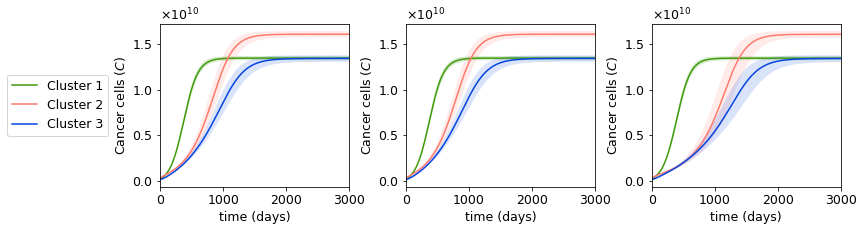

Varying lamC-lamCmu1 assumption + perturb sensitive params by 10%


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpa

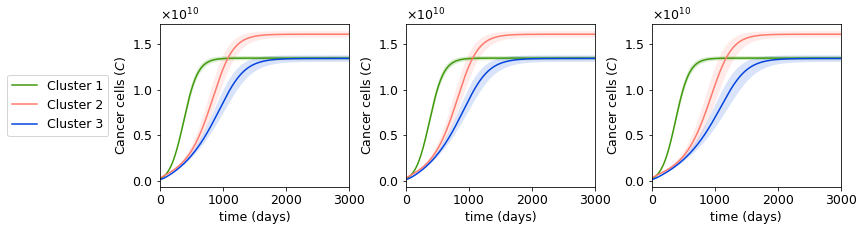

Varying delCIg-delC assumption + perturb sensitive params by 10%


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpa

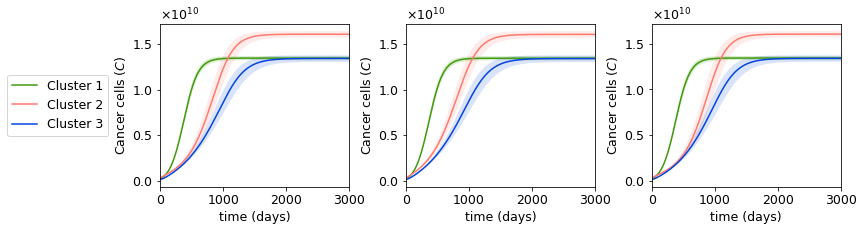

Varying delCTc-delC assumption + perturb sensitive params by 10%


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpa

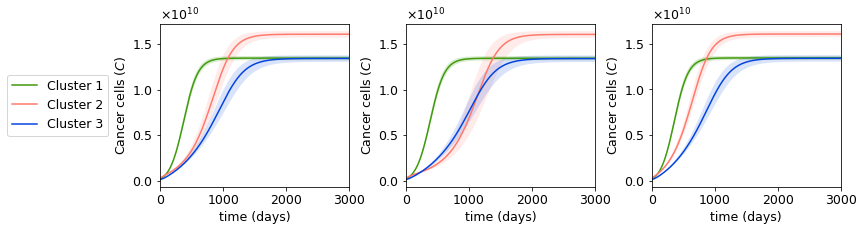

Varying lamMIg-lamMmu1 assumption + perturb sensitive params by 10%


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


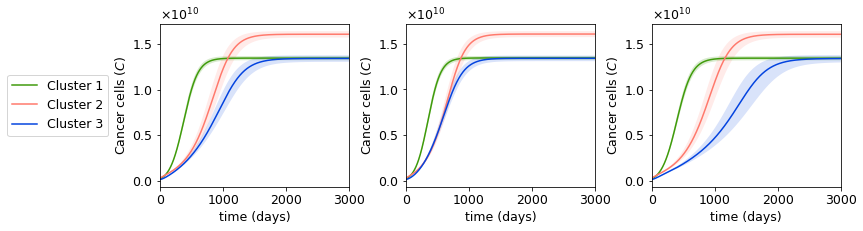

In [22]:
for i in range(1, 6):
    print('Varying', restriction_map[i], 'assumption + perturb sensitive params by 10%')
    plot_cancer_vary_assumption_perturb_sensitive_params(assumption_idx=i, assumption_scale=5, perturb_scale=1, T=3000)

### Plot dynamics with cross-cluster initial conditions

In [9]:
# reading initial conditions
IC=pd.read_csv('input/TARGET_nondimensional_initial_conditions.csv')
IC.drop('Unnamed: 0', axis=1, inplace=True)
IC = IC.to_numpy()

In [12]:
def plot_cross_cluster_IC(cluster, T, title=None):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import seaborn as sns
    
    QSP_=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
    clusters = [c for c in range(3) if c != cluster]
    dynamic_all = []
    
    for c in clusters:
        dynamic_df = pd.DataFrame(columns=['time (days)', 'Cluster']+QSP_.variable_names())
        t = np.linspace(0, T, 10*T+1)
        dynamic_df['time (days)'] = t
        dynamic_df['Cluster'] = ['Cluster '+str(c+1)]*len(dynamic_df['time (days)'])
        
        u, _ = QSP_.solve_ode(t, IC[c], 'given')
        u = clustercells[cluster]*u
        dynamic_df[QSP_.variable_names()] = u
        dynamic_df['Total cells'] = dynamic_df[dynamic_df.columns[2:-4]].sum(axis=1)
        dynamic_all.append(dynamic_df)
        
    dynamic_all_df = pd.concat(dynamic_all, axis=0)
    
#     fig, axs = plt.subplots(3, 5, sharey=False, figsize=(18.5,10))
#     fig.subplots_adjust(wspace=0.33, hspace=0.25)
#     axs = axs.flatten()
#     palette={'Cluster 1':'#3F9B0B', 'Cluster 2':'#FF796C', 'Cluster 3':'#0343DF'}
#     plt.rcParams.update({'font.size': 12.5})
    
    fig, axs = plt.subplots(3, 5, sharey=False, figsize=(21.5,12))
    fig.subplots_adjust(wspace=0.38, hspace=0.35)
    axs = axs.flatten()
    palette={'Cluster 1':'#3F9B0B', 'Cluster 2':'#FF796C', 'Cluster 3':'#0343DF'}
    plt.rcParams.update({'font.size': 15})
    
    custom_lines = [[Line2D([0], [0], color='#FF796C', lw=1.5), Line2D([0], [0], color='#0343DF', lw=1.5)],
                    [Line2D([0], [0], color='#3F9B0B', lw=1.5), Line2D([0], [0], color='#0343DF', lw=1.5)],
                    [Line2D([0], [0], color='#3F9B0B', lw=1.5), Line2D([0], [0], color='#FF796C', lw=1.5)]]
    cluster_names = [['Cluster 2', 'Cluster 3'],
                     ['Cluster 1', 'Cluster 3'],
                     ['Cluster 1', 'Cluster 2']]
    
    for i, col in enumerate(dynamic_all_df.columns[2:]):
        sns.lineplot(data=dynamic_all_df, x='time (days)', y=col, hue='Cluster', palette=palette, ax=axs[i], legend=False)
        axs[i].margins(x=0)
        axs[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axs[i].yaxis.major.formatter._useMathText = True
        
    axs[9].legend(custom_lines[cluster], cluster_names[cluster], bbox_to_anchor=(1.08, 0.5), loc='center left')
        
    if title==None: title = str(cluster+1)
    fig.savefig('Dynamics_cross_cluster_IC_cluster'+title+'.pdf', bbox_inches='tight')
    fig.savefig('Dynamics_cross_cluster_IC_cluster'+title+'.eps', bbox_inches='tight')
    plt.show()


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


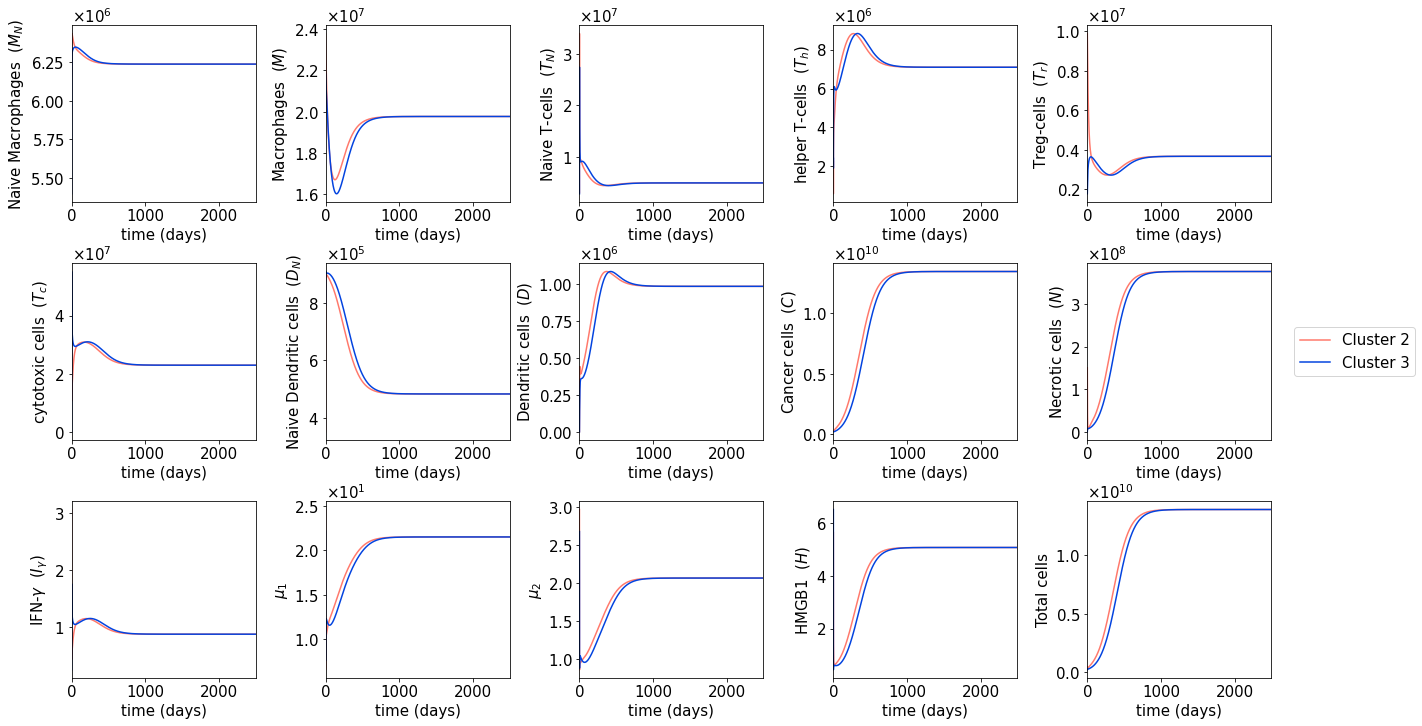

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


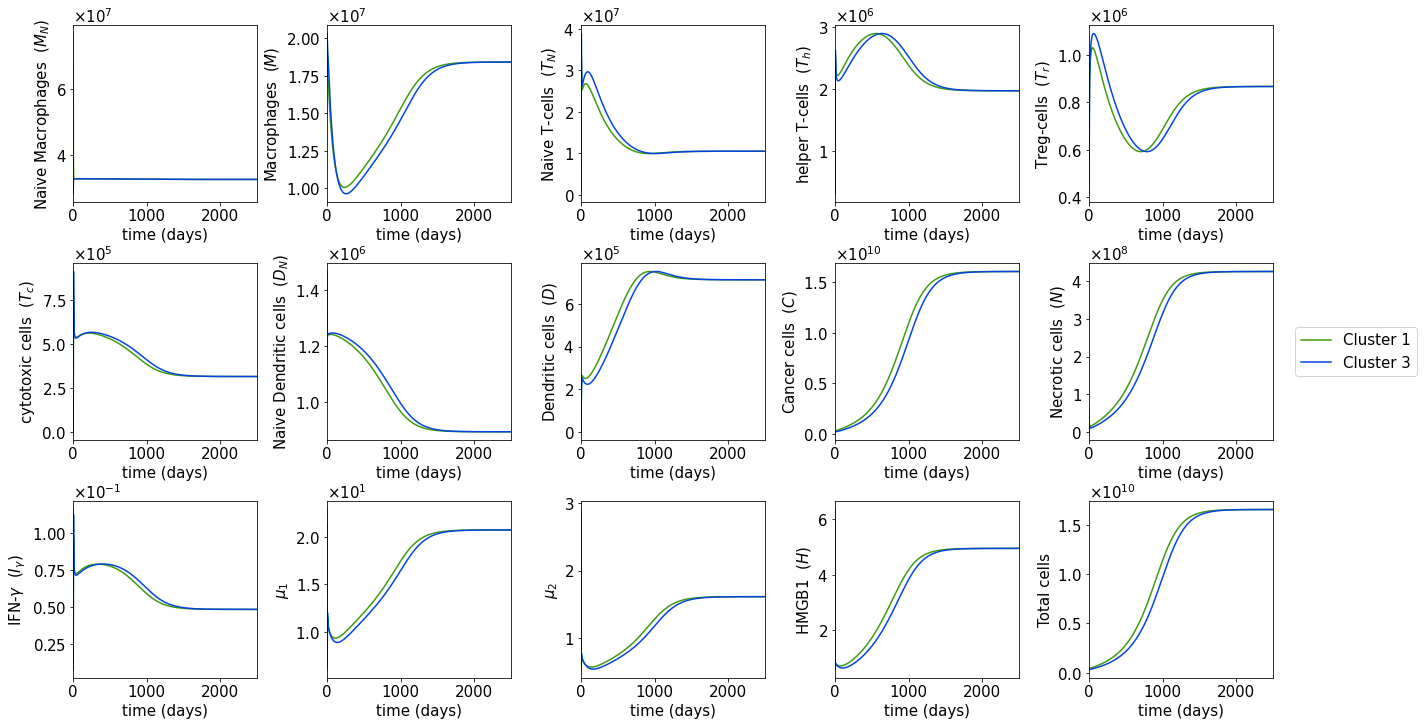

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


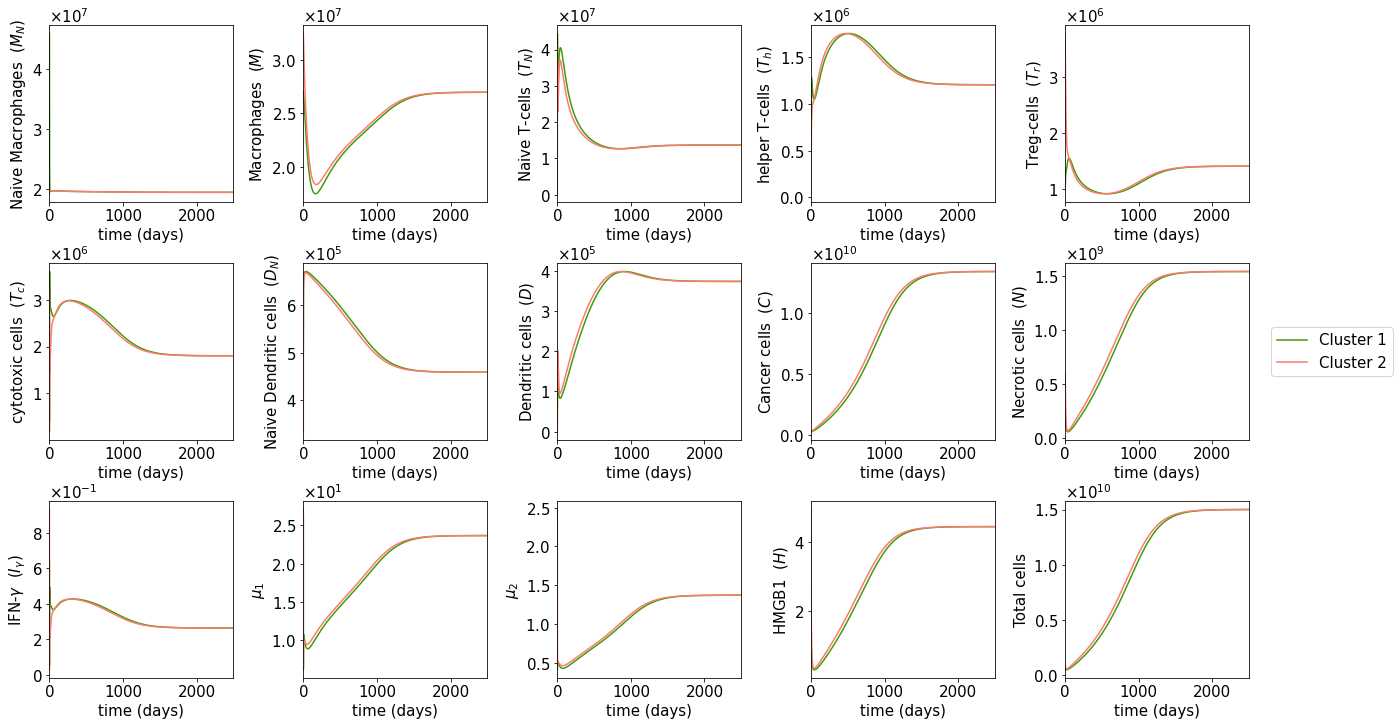

In [13]:
for c in range(3):
    plot_cross_cluster_IC(c, 2500)

### Plot dynamics with varying initial conditions

In [14]:
cols = ['Mn', 'M', 'Tn', 'Th', 'Tr', 'Tc', 'Dn', 'D', 'C', 'N', 'Ig', 'mu1', 'mu2', 'H', 'Cluster']

df = pd.read_csv('input/TARGET_all_patients_data.csv')
df.set_index('Unnamed: 0', inplace=True)
df.dropna(axis=0, inplace=True)
df = df[cols + ['percent_tumor']]
df.head()

,Mn,M,Tn,Th,Tr,Tc,Dn,D,C,N,Ig,mu1,mu2,H,Cluster,percent_tumor
Unnamed: 0,,,,,,,,,,,,,,,,
TARGET-40-PAKFVX,33629409.97,17645374.73,1.049361e+07,9.484432e+05,1.481133e+06,1.894498e+05,4.948644e+05,3.419257e+05,7.506561e+09,6.152919e+08,0.035624,19.728295,0.567939,4.699896,Cluster 2,91.5
TARGET-40-PAKUZU,28848811.15,18730890.19,1.101613e+07,1.810208e+06,1.409581e+06,9.640899e+05,7.571538e+05,3.507186e+04,5.069762e+09,2.651876e+09,0.037734,23.853839,1.082637,4.340349,Cluster 2,65.0
TARGET-40-PAKXLD,22430044.55,14192485.17,1.195665e+07,3.863636e+06,3.783082e+05,1.982317e+06,0.000000e+00,1.296401e+06,1.238594e+10,9.424082e+08,0.000000,26.673689,3.039737,4.219881,Cluster 1,92.0
TARGET-40-PAKZZK,23932459.62,28168602.30,9.429999e+06,8.420718e+05,1.186648e+06,1.774748e+06,1.022503e+05,0.000000e+00,1.799620e+09,5.805226e+07,0.000000,22.719933,4.397625,4.626182,Cluster 3,93.0
TARGET-40-PALECC,32149982.04,17356605.60,8.882329e+06,4.474060e+06,4.788916e+05,0.000000e+00,2.033885e+06,1.499655e+05,1.428012e+09,2.060418e+09,0.000000,23.929319,1.913239,5.727727,Cluster 2,35.0


In [15]:
cutoffs = []
for cluster in range(3):
    dat = df[df.Cluster == 'Cluster '+str(cluster+1)].drop('Cluster', axis=1)
    cutoff = dat['C'].quantile(q=0.85, interpolation='nearest')
    cutoffs.append(cutoff)
    
cutoffs

[12918010469.0, 15518548627.0, 9936499133.0]

In [18]:
def plot_varying_IC(df, cluster, T, title=None, cutoff=cutoffs[cluster], cols=cols):
    import matplotlib.pyplot as plt
    import seaborn as sns

    dat = df[(df.Cluster == 'Cluster '+str(cluster+1)) & (df.C <= cutoff)][cols].drop('Cluster', axis=1)
    dynamic_all = []
    
    for patient in dat.index:
        QSP_=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
        
        dynamic_df = pd.DataFrame(columns=['time (days)', 'patient']+QSP_.variable_names())
        t = np.linspace(0, T, 10*T+1)
        dynamic_df['time (days)'] = t
        dynamic_df['patient'] = [patient]*len(dynamic_df['time (days)'])
        
        IC = np.array(dat.loc[patient])/clustercells[cluster]
        u, _ = QSP_.solve_ode(t, IC, 'given')
        u = clustercells[cluster]*u
        dynamic_df[QSP_.variable_names()] = u
        dynamic_df['Total cells'] = dynamic_df[dynamic_df.columns[2:-4]].sum(axis=1)
        
        dynamic_all.append(dynamic_df)
        
    dynamic_all_df = pd.concat(dynamic_all, axis=0)
    
    fig, axs = plt.subplots(3, 5, sharey=False, figsize=(18.3,10))
    fig.subplots_adjust(wspace=0.38, hspace=0.35)
    axs = axs.flatten()
    plt.rcParams.update({'font.size': 12.5})

    for i, col in enumerate(dynamic_all_df.columns[2:]):
        sns.lineplot(data=dynamic_all_df, x='time (days)', y=col, hue='patient', ax=axs[i], legend=False)
        axs[i].margins(x=0)
        axs[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axs[i].yaxis.major.formatter._useMathText = True
        
    if title==None: title = str(cluster+1)
    fig.savefig('Dynamics_varying_IC_cluster'+title+'.pdf', bbox_inches='tight')
    fig.savefig('Dynamics_varying_IC_cluster'+title+'.eps', bbox_inches='tight')

    plt.show()

C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


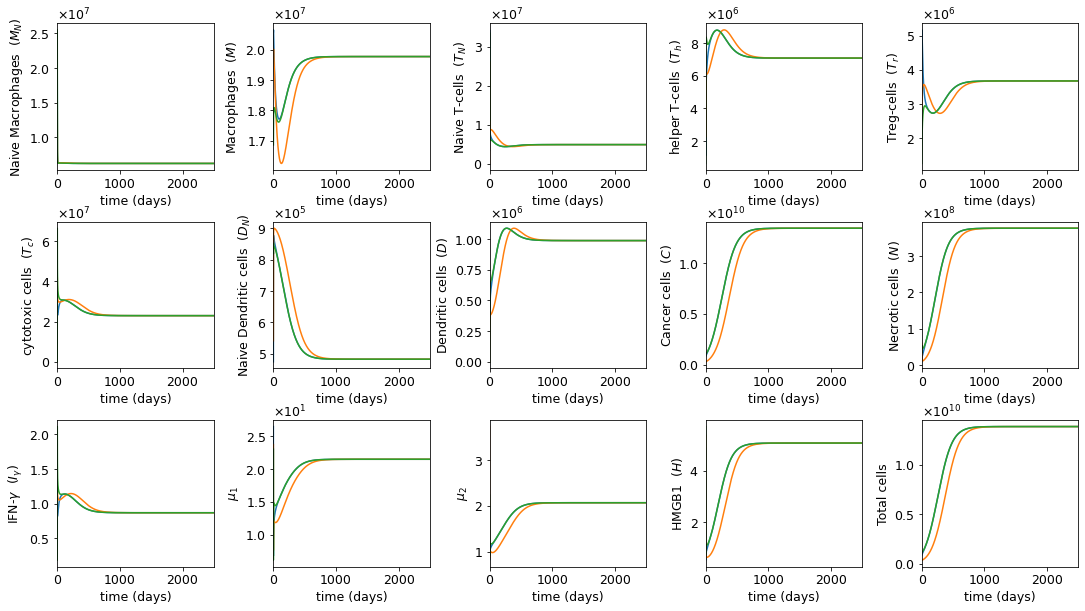

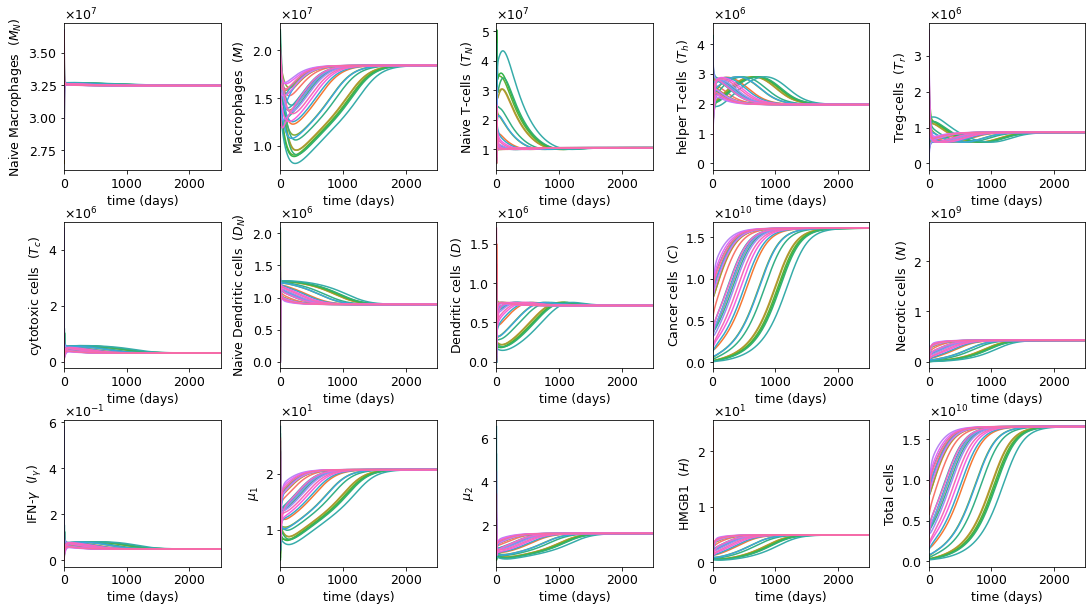

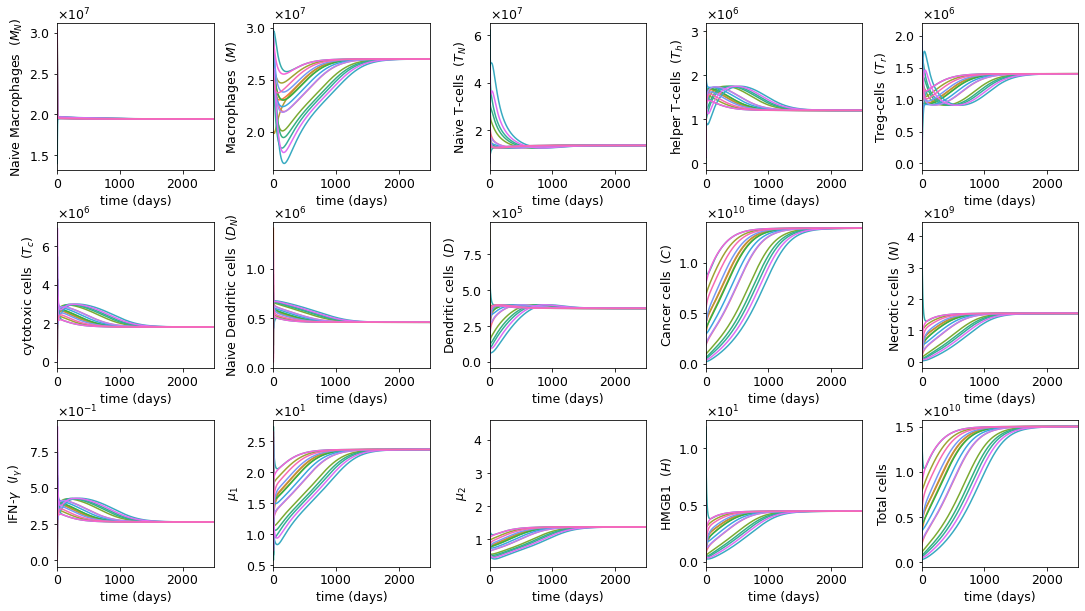

In [19]:
for c in range(3):
    plot_varying_IC(df, c, 2500)